#### This notebook contains an implementation of the dynamical modularity algorithm as described in the arxiv preprint (https://arxiv.org/abs/2303.16361).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
# ABOVE added to use development version of cana
from __future__ import division
import os
import math
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2g}'.format
import graphviz
import cana
from cana.drawing.canalizing_map import draw_canalizing_map_graphviz 

import matplotlib as mpl
import matplotlib.style
from matplotlib.text import Text
from matplotlib.patches import Circle, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection
import random
from copy import copy
mpl.rc('font', **{'size':16})
import matplotlib.pyplot as plt
from cana.datasets.bio import THALIANA, DROSOPHILA, BUDDING_YEAST, LEUKEMIA, BREAST_CANCER
from itertools import combinations
from IPython.display import display, Image, Latex, SVG, HTML
import subprocess

import json
import ast

import networkx as nx
from cana.boolean_network import BooleanNetwork 

**Load the toy network**

In [2]:
N = BooleanNetwork.from_file("./test-BN.txt", keep_constants=True, name = 'example') 

# Load biological networks stored in cana
# ND = DROSOPHILA()
# NL = LEUKEMIA()
# NB = BREAST_CANCER()
# NT = THALIANA()
# NY = BUDDING_YEAST()

[(0, {'label': 'i1'}), (1, {'label': 'i2'}), (2, {'label': 'g1'}), (3, {'label': 'g2'}), (4, {'label': 'P1'}), (5, {'label': 'P2'})]
Nodes: 6 | Edges: 8


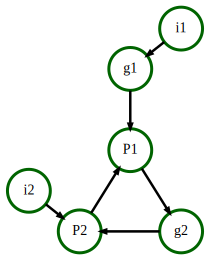

In [3]:
Nsg = N.structural_graph()
print(Nsg.nodes(data=True))
nodes = {d['label']:i for i,d in Nsg.nodes(data=True)}
att = {}

x,y = np.linspace(0,500,5,dtype=int), np.linspace(500,0,6,dtype=int)
att['i1']    = {'x':x[3],'y':y[0],'fillcolor':'#4f6fb0','label':'i1','shape':'circle'}
att['i2']    = {'x':x[0],'y':y[4],'fillcolor':'#4f6fb0','label':'i2','shape':'circle'}
att['g1']    = {'x':x[2],'y':y[1],'fillcolor':'#4f6fb0','label':'g1','shape':'circle'}
att['P1']    = {'x':x[2],'y':y[3],'fillcolor':'#4f6fb0','label':'P1','shape':'circle'}
att['g2']    = {'x':x[3],'y':y[5],'fillcolor':'#4f6fb0','label':'g2','shape':'circle'}
att['P2']    = {'x':x[1],'y':y[5],'fillcolor':'#4f6fb0','label':'P2','shape':'circle'}

S = graphviz.Digraph(name='Structural Graph', engine='neato')
S.attr('graph', concentrate='false', simplify='false', overlap='false',splines='false',pad='0.1', ranksep='5', nodesep='50',)
S.attr('node', fixedsize='true', width='.60')#, color='gray', style='filled', fillcolor='#515660', penwidth='3', 
#       fontname='Helvetica', fontcolor='ghostwhite',fontsize='12')
S.attr('edge', arrowhead='normal', arrowsize='0.5', color='#545454')
keepers=[Nsg.nodes[n]['label'] for n in Nsg.nodes()]

for node,d in Nsg.nodes(data=True):

    if d['label'] in att:
        natt = att[d['label']]
        if 'x' in natt or 'y' in natt:
            x,y = natt['x'] , natt['y']
            xy = '%.2f,%.2f!' % (x/72,y/72)
        if 'fillcolor' in natt:
            fillcolor = natt['fillcolor']
        else:
            fillcolor = '#515660'
    else:
        xy = 'false'
        fillcolor = '#515660'
    if d['label'] in keepers:
        S.node(name=str(node), label=natt['label'], pos=xy, fillcolor=fillcolor,shape=natt['shape'], color='darkgreen', penwidth='3')

max_penwidth = 2.5
for s,t,d in Nsg.edges(data=True):
    if s==t: continue #include this line to get rid of self-loops
    #print Nsg.node[s]['label']
        
    if (Nsg.nodes[s]['label'] not in keepers) or (Nsg.nodes[t]['label'] not in keepers): 
        continue #include this line to view only interactions we want
    weight = '%d' % (d['weight']*100)
    penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    if 'example' in Nsg.name and s==5 and t==3:
        S.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled, minlen='2', color='black', arrowhead='tee', arrowsize='1.0')
    else:
        S.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled, minlen='2', color='black')
print ('Nodes: %d | Edges: %d' % (len(Nsg.nodes()) , len(Nsg.edges()) ))
# Display
display(SVG(S.pipe(format='svg')),metadata={'isolated':True})

**Draw the DCM**

Simplified DCM


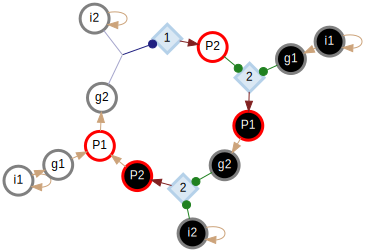

Black units -> ON nodes 
White units -> OFF nodes


In [4]:
# Draw the DCM
DCM = N.dynamics_canalization_map(output=None, simplify=True) # simplifly = True (default) removes most of threshold=1 nodes and replaces them with fusion nodes
D = draw_canalizing_map_graphviz(DCM, overlap='true')
print("Simplified DCM")
display(D)
print("Black units -> ON nodes \nWhite units -> OFF nodes")

Non-simplified DCM


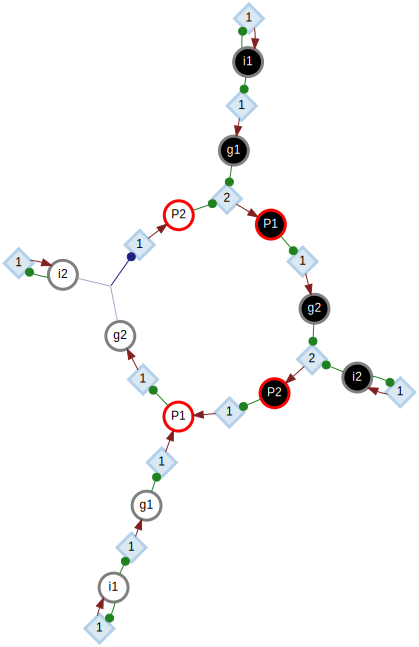

In [5]:
# to verify usage of 'simplify=True/False' in the dynamics_canalization_map function, plot the DCM with simplify=False
DCM2 = N.dynamics_canalization_map(output=None, simplify=False) 
D2 = draw_canalizing_map_graphviz(DCM2, overlap='true')
print("Non-simplified DCM")
display(D2)

**Functions leading to the estimation of dynamical modularity**

In [6]:
import random
#threshold network conversion
def create_threshold_network(n):
    """ 
    Create a digraph compatible with threshold network manipulation
    Expects a DCM-like digraph as input, returns a threshold-like digraph where every node is a literal and/or threshold node
    
    Valid nodes include these properties: label, threshold (tau), type, time delay, variable, state
    Valid edges include these properties: type 
    
    NOTE: the DCM originally has a separate fusion node for each literal enput of the same state involved in the same symmetry group
    However, this means that the same enput can activate multiple edges rather than just one
    As a solution, each group of fusion nodes that are associated with the same state and the same symmetry group are replaced
    by one threshold node with tau=n, where n is the number of fusion nodes that were combined into that threshold node 
    """
    
    n=n.copy() #don't change the original graph
    
    #check for similar fusion nodes
    fusion_nodes=[name for name in n.nodes() if n.nodes[name]['type']=='fusion']
    groups={} #each group will share the same predecessors and successors
    i=0
    for f in fusion_nodes:
        predecessors=set(n.predecessors(f))
        successors=set(n[f])
        found=False
        for key in groups:
            if groups[key]['predecessors']==predecessors and groups[key]['successors']==successors: #we have a match
                groups[key]['nodes'].append(f)
                found=True
                break
        if not found: #make a new group
            groups[i]={'predecessors':predecessors, 'successors':successors, 'nodes':[f]}
            i+=1
    #delete fusion nodes and replace with new threshold nodes
    for t in groups: #add new threshold nodes
        name="F-T"+str(t)
        tau=len(groups[t]['nodes'])
        group=n.nodes[random.choice(tuple(groups[t]['successors']))]['group'] #take group attribute of random successor, necessary for visualization

        # n.add_node(name,{'label':str(tau),'type':'threshold','tau':tau,'group':group}) # DOES NOT WORK  
        # node attributes must be added manually -- MODIFIED CODE
        n.add_node(name)
        n.nodes[name]['label']=str(tau)
        n.nodes[name]['type']='threshold'
        n.nodes[name]['tau']=tau
        n.nodes[name]['group']=group


        #adjust successor node thresholds; add 1 for new threshold node and then subtract for each fusion node deleted
        for successor in groups[t]['successors']: #there should only be one
            n.add_edge(name,successor)
            n.nodes[successor]['tau'] += 1 - tau
            n.nodes[successor]['label'] = str(n.nodes[successor]['tau'])
        #add new edges to threshold nodes from predecessors
        for predecessor in groups[t]['predecessors']:
            n.add_edge(predecessor,name)
        
    #delete fusion nodes and adjacent edges
    for f in fusion_nodes:
        n.remove_node(f)
    #print groups
    
    for name in n.nodes():
        
        if 'label' not in n.nodes[name]:
            n.nodes[name]['label']='unknown'
            
        if 'type' not in n.nodes[name]:
            n.nodes[name]['type']='unknown'
            
        if 'tau' not in n.nodes[name]:
            if n.nodes[name]['type']=='threshold':
                n.nodes[name]['tau']=1
            else:
                n.nodes[name]['tau']=0
                
        if 'delay' not in n.nodes[name]:
            if n.nodes[name]['type']=='threshold':
                n.nodes[name]['delay']=0
            else:
                n.nodes[name]['delay']=1
        
        #assume variable name comes from the label
        if 'variable' not in n.nodes[name] and n.nodes[name]['type']=='variable':
            n.nodes[name]['variable']=n.nodes[name]['label'] # assign name of node to variable property
            
        #assume states are only positive integers
        if 'state' not in n.nodes[name] and n.nodes[name]['type']=='variable':
            state_str=name.replace(n.nodes[name]['variable'],"") #remove variable name
            state_str=''.join([s for s in state_str if s.isdigit()]) #concatenate string from all integers left in name (in case of double-digit states)
            n.nodes[name]['state']=int(state_str)
                
        
    return n


In [7]:
from collections import deque
# specialized BFS to work for threshold network
def BFS_threshold(n,seed,input_type='steady',time_limit=1,conversion=True,name_conversion=True):
    """
    BFS -> Breadth-First Search algorithm

    n : DCM representation of a network
    
    -> Does specialized BFS on a threshold network n
    -> input_type may be 'pulse' if a single signal is sent through the network (seed guaranteed ON/OFF for only one time step)
       or 'steady' if the signal is held on (seed guaranteed ON/OFF for all time steps) 
    -> seed may be a single node or a list of starting nodes

    -> not sure if input_type='pulse' logic works correctly
    
    Implementation based on BFS with a priority queue of times {t: q} 
    where t is the time when those nodes become active and q are the nodes active at that time step 
    
    Returns a dictionary of nodes visited at each time step
    
    NOTE: a threshold network is required, this will break if fusion nodes have not been removed
    Assume that a conversion is needed; will not run conversion if conversion argument set to False 
    
    NOTE: if run with input_type='steady', unfolding contains only the new states visited at that time step
    while all previous states visited are also considered active
    if run with input_type='pulse', unfolding contains EVERY node that is active at that time step, 
    even if it has been active before 
    
    NOTE: if run with input_type='steady', then ignore any node that is a different state of the starting seed;
    because we are pinning control of that variable, we need to remove all other possible variable states from the network """
    
    if conversion: # conversion is slow due to a network deep copy 
        try:
            n=create_threshold_network(n)
        except:
            raise Exception("Network could not be converted to a thresholded representation") 
        
    # from this point onwards, n is a threshold network (modified representation)
        
    if not isinstance(seed,list): #convert seed to a list if it is a single node
        seed=[seed]

    # ***********************************************************************************************
    # convert seed names from i1-1, i2-0, etc to a version that is compatible with the DCM network 
    # -- var-0-out-1, var-1-out-0, etc -- REPORT THIS AS AN ISSUE IN THE CANA GITHUB
    # Build lookup dict: (label, value) -> node

    if name_conversion:
        lookup = {
            (attrs["label"], str(attrs["value"])): node
            for node, attrs in n.nodes(data=True)
            if attrs.get("type") == "variable"
        }

        # Collect matching nodes
        mod_units = [
            lookup[(label, state)]
            for label, state in (name.split("-") for name in seed)
            if (label, state) in lookup
        ]

        seed = mod_units

    # ***********************************************************************************************

    for node in seed:
        if node not in n.nodes():
            raise Exception(f'Seed node {node} not in the network!  Hint: did you specify both the node and current state? e.g. wg-1')
            
    #if there is steady-state input (pinning control), note any contradictions to any node in the seed
    #NOTE: if given a logical contradiction, this function picks only ONE of the states to use
    #however, this doesn't affect steady-state (because the variable was already added to the queue and active step)
    if input_type=='steady':        
        # retrieve node names and states for each 'seed' node
        # here, n.nodes[x]['variable'] contains the actual name of the node: e.g. 'wg', 'i2', etc.
        # n.nodes[x]['state'] contains the state of that node depending on node-id: e.g. '21', '20' -- for state 1 and 0 of node_id=2 (here, 'i2')
        # use n.nodes[x]['value'] instead since it already has the actual binary state (0 or 1) for each variable node
        
        vals={n.nodes[x]['variable']:n.nodes[x]['value'] for x in seed if n.nodes[x]['type']=='variable'} 

        # seed nodes are specified with states, so we need to ensure that the initial nodes+states for these nodes in the network are not contradictory
        # if contradiction exists, store nodes in a set to be ignored during BFS
        contradictory_nodes={node for node in n if 
                        n.nodes[node]['type']=='variable' and n.nodes[node]['variable'] in vals and n.nodes[node]['value']!=vals[n.nodes[node]['variable']]}
    else:
        contradictory_nodes={}
        
    counter=0  #this will increment towards the time limit and provide an exit if we get stuck
    visited=set() #visited nodes during the entire history
    thresholds={} #global threshold dictionary to populate with discounted threshold nodes
        
    # create 'priority queue', actually a dictionary of time steps due to difficulty in changing priorities in a heap
    time_steps={0: deque(seed)} #FIFO queue for each time step of nodes to attempt to visit
    time=0 #global chronometer, iterates by one as dynamic unfolding takes place
    unfolding={} #track the unfolding of the dynamics over iterated time, mirrors time_steps but only holds visited nodes    
    active_step=set(seed) #active nodes for this time step, will be different than visited if input_type='pulse'
    
    while time<=max(time_steps): # allows for possibility of time jumps, i.e. updates further ahead than one time step
        
        # update counter
        old_length=len(visited)
        visited.update(active_step)

        if len(visited)==old_length: #increase counter if we have not added anything new
            counter+=1

        # reset thresholds and active_step if this is pulse (so that we may revisit nodes, including the starting nodes)
                
        if input_type=='pulse':
            thresholds={}
            active_step=set()
        
        # check for exit due to being stuck in a cycle
        if counter>=time_limit: 
            break 

        # run BFS
        while time_steps.get(time): 

            node=time_steps[time].popleft() # retrieve the next node to visit from the queue
            # add node to unfolding
            unfolding.setdefault(time,set())
            unfolding[time].add(node)
            
            # check neighbors - note that for steady state we assume all past actors are still activated, but pulse requires repeat activation
            for neighbor in n[node]:

                # ignore any contradictory nodes; better to ignore than remove because we don't want BFS to be destructive to the graph
                if neighbor in contradictory_nodes:
                    continue

                if neighbor not in active_step:
                    # check that neighbor passes the threshold test if it has a non-trivial threshold
                    if n.nodes[neighbor]['tau']>1:
                        # This implies that a threshold (>1) exists for this neighbour, and that the current (predecessor) 'node' has been activated. 
                        # Therefore, net score (of incoming) activated edge += 1 -- which is tracked by adding 'node' to list of active predecessors to this neighbor 
                        thresholds.setdefault(neighbor,set())
                        thresholds[neighbor].add(node)  # add node due to this incoming edge, ensures node can only contribute once

                    if neighbor not in thresholds or len(thresholds[neighbor])>=n.nodes[neighbor]['tau']:
                        # at this point we have passed the threshold, so insert neighbor at proper time slot t
                        t = time + n.nodes[neighbor]['delay']
                        time_steps.setdefault(t,deque())
                        time_steps[t].append(neighbor) # at time_steps[t], neighbor will be visited
                        active_step.add(neighbor) 
                           
        # next iteration
        time+=1
    
    return unfolding


In [8]:
from matplotlib import colors

def visualize_unfolding(n,seed,node_set=None,node_ranges=None,input_type='steady',time_limit=1,conversion=True,name_conversion=True,
                        figsize=(10,10),interference=True,rotation=45,fontsize=16,fontweight=None,labels=True):

    """ 
    Visualize one pathway by using a grid-like representation of node states.   
    
    Code from https://github.com/brahmcapoor/cellular-automata/blob/master/main.py   

        -> Can visualize using thresholded network or the original DCM   
        -> Expects a node_set of which nodes we want to display on the x-axis or else uses all variables by default     
        -> If interference is True, we assume a node's state during only one time step with pulse input  
        -> If interference is False, we assume a node keeps its state until it is changed with pulse input   
        -> Rotation changes the rotation of the x-axis labels; for simplicity, fontsize and fontweight apply to both axes and the ylabel   
        -> Setting labels to False suppresses any axis labels from being shown   
    """
    
    # TODO: allow for node ranges to be set to express full range of states (normalized to 0 to 1)
    
    if conversion:
        try:
            n=create_threshold_network(n)
        except:
            raise Exception("Network could not be converted to a thresholded representation")
            
    if not node_set: # use all variables from the network
        node_set={n.nodes[x]['variable'] for x in n if n.nodes[x]['type']=='variable'}
        
    # determine pathway -- get list of nodes visited in each time step <= time_limit or till no further nodes can be visited
    unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=not conversion, name_conversion=name_conversion) 
    
    xvalues=list(node_set) # get list of nodes
    time=max(unfolding) # gives the final time_step of pathway unfolding 
    grid=[[-1 for x in xvalues] for t in range(time+1)] #use -1 for wildcard value to accomodate multi-state nodes
    
    # visualize unfolding, assumes variable can only be in one state at one time step
    for t in range(time+1): # make sure to include time 0 and time t
        vals={n.nodes[x]['variable']:n.nodes[x]['state'] for x in unfolding[t] if n.nodes[x]['type']=='variable'} # ensuring node_type='variable' skips the threshold/fusion nodes
        
        # here, however, the node states are stored as {node_id}{node_state} which implies that all nodes have states >=10 (for node_id >= 1) -- can cause visualization issues
        # this can be resolved by modifying the last few lines in the create_threshold_network() method

        for i,x in enumerate(xvalues):
            if x in vals: 
                # if you want to use the below line instead, specify n.nodes[x]['value'] instead of 'state' to retrieve binary states
                # grid[t][i]=vals[x] # since states are not simply 1s or 0s, replace with line below ***************** 
                grid[t][i] = vals[x]%10

                #if this is steady_state, assume this condition holds for the rest of time (or if no interference is assumed)
                if input_type=='steady' or not interference:
                    for t2 in range(t+1,time+1):
                        grid[t2][i]=vals[x]%10 # added '%10' to bring state values back to 0 or 1 (by removing node_id)

    #print unfolding, grid 

    #TODO: create gradation for multi-state
    cmap = colors.ListedColormap(['grey', 'white', 'black'])
    bounds = [-1, 0, 1, 1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    ax.set_xticks(np.linspace(-0.5,len(node_set)-1.5,num=len(node_set))) #major ticks used for grid
    ax.set_xticks(np.linspace(0,len(node_set)-1,num=len(node_set)),minor=True) #minor ticks used for labeling
    ax.set_yticks(np.linspace(-0.5,time-0.5,num=time+1)) #major ticks used for grid
    ax.set_yticks(np.linspace(0,time,num=time+1),minor=True) #minor ticks used for labeling
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    if labels:
        ax.set_xticklabels(list(node_set),rotation=rotation,minor=True,fontsize=fontsize,fontweight=fontweight)
        ax.set_yticklabels([t for t in range(time+1)],minor=True,fontsize=fontsize,fontweight=fontweight)
        plt.ylabel("time",fontsize=fontsize,fontweight=fontweight)
    plt.grid()
    
    grid = plt.imshow(grid, interpolation='nearest', cmap=cmap,norm=norm)
    #plt.show()
    return fig,ax


In [9]:
# function to find all pathway modules for a given set of seed nodes 
# previously named find_dynamic_modules()
def find_pathway_modules(n,s=1,input_type='steady',time_limit=1,conversion=True,samples=None,seeds=None):
    
    """ 
    Test all possible seeds of a network to determine each seed's dynamic unfolding.

        -> n: DCM representation of a network
        -> input_type: may be 'pulse' if a single signal is sent through the network (seed guaranteed ON/OFF for only one time step),
           or 'steady' if the signal is held on (seed guaranteed ON/OFF for all time steps). 
        -> s: dictates how many nodes the seed should contain, i.e., size of seed set; the default is to only search for dynamic modules 
           with one starting node

    NOTE: This function does a combinatoric search over all possible seed configurations, be careful with memory constraints
    when running with large # of nodes.

        -> If samples=x, then this will draw x samples from the possible combinations with replacement
        -> If tm=True, this will try to compute all top modules
        -> If seeds is not None, this will find all dynamic modules from the seeds contained in that iterable (must be hashable);
        -> Note that seeds takes precedence over samples
    
    *** Converts the network n to a thresholded representation ***
    
    """
    
    # perform network conversion now itself since we want to store variable nodes in a list immediately
    # instead, set conversion=False in the BFS_threshold function call since already converted.
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
    
    network_unfolding, sizes = {}, {}

    # remove all non-variable nodes for cleaner visibility and comparison
    nodes = [x for x in n if n.nodes[x]['type']=='variable']
    """
    Here, by using node names from the converted threshold DCM, node names are already guaranteed to conform 
    to the updated CANA DCM naming convention, e.g, var-0-out-0, var-0-out-1, etc. 
    Therefor, name conversion inside BFS is not required.
    """
    # if seeds are not specified, either find all combinations of seeds of size s, or sample from possible combinations
    if not seeds:
        if samples: # sampling to avoid memory issues with high combinations
            # seeds=[[random.choice(nodes) for j in range(s)] for i in range(samples)] # this gives samples with replacement -- might produce duplicates
            # let's generate samples without duplicates 
            seeds = [random.sample(nodes, s) for _ in range(samples)] # this generates 's' sized samples without replacement -- may lead to errors if s > # of nodes in the network
            
            # NOTE: there may still be contradictions within each seed sample 
            # -- i1-0 & i1-1 may be in the same seed group -- 
            # however, this is resolved within the BFS_threshold() method

        else: # get all possible combinations of size s
            seeds=combinations(nodes,s)

    candidates={} # translator dictionary

    # Here, all seed sets are of the SAME size s
    for seed in seeds:
        # retreive one seed set at a time
        seed = list(seed) # typecast to list
        
        # quick check for contradiction
        vals = [n.nodes[x]['variable'] for x in seed] # retrieve variable names: i1, i2, etc.
        if len(set(vals))<len(vals): 
            # we have multiple nodes sharing the same variable, e.g., i1-0 and i1-1 are both in the seed -- not allowed
            continue
        
        unfolding = BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=not conversion, name_conversion= not conversion)        

        # the next line of code does the same job as the module_reduce() method
        unfolding = {t:{x for x in unfolding[t] if n.nodes[x]['type']=='variable'} for t in unfolding} # simplify by removing all non-variable nodes from the unfolding
        
        
        # create dictionary where key=seed, value=unfolding
        network_unfolding[str(seed)] = unfolding 
        sizes[str(seed)] = sum([len(unfolding[t]) for t in unfolding])
        
        # update candidates
        candidates[str(seed)]=set(seed) # translator dictionary that returns list of actual seed nodes from their string representation
  
    return network_unfolding,sizes,candidates


In [11]:
from itertools import combinations
from collections import defaultdict

def _pathway_set_from_unfolding(unfolding, graph=None, input_type='steady', variable_only=True):
    """
    Return the pathway module set S = ⋃_t S^t. 
    If graph is provided and variable_only=True, keep only nodes with graph.nodes[x]['type']=='variable'.
    """
    if input_type == 'steady':
        # union of all nodes that ever fire
        S = set().union(*[set(unfolding[t]) for t in unfolding]) if unfolding else set()
    else:
        # pulse or other: still use union over time for S
        S = set().union(*[set(unfolding[t]) for t in unfolding]) if unfolding else set() 
        
    if graph is not None and variable_only:
        S = {x for x in S if graph.nodes.get(x, {}).get('type') == 'variable'}

    return S

def _canonical_seed_key(seed_nodes):
    """
    Make a stable string key for a seed set (order independent).
    """
    return "|".join(sorted(seed_nodes))

def _ensure_unfolding_for_seed(seed_nodes, nu, threshold_graph, input_type='steady', time_limit=1):
    """
    Fetch unfolding from nu if present, otherwise compute via BFS_threshold.
    """
    key = str(tuple(sorted(seed_nodes))) 

    if key in nu:
        return nu[key]
 
    # Fallback: compute
    return BFS_threshold(threshold_graph, list(seed_nodes), input_type=input_type, time_limit=time_limit, conversion=True, name_conversion=False)



In [ ]:
def find_complex_modules(
    nu,                 # dict: seed-string -> unfolding {t: [nodes]}
    candidates,         # dict: seed-string -> set(nodes)  (actual node names as used in threshold_DCM)
    threshold_graph,    # the threshold DCM produced by create_threshold_network(DCM)
    s,                  # seed size for which complex modules are to be found
    input_type='steady',
    time_limit=1,
    variable_only=True,
    allow_on_the_fly=True
):
    """
    Return dict of complex modules for seed size s:
      key: canonical seed-key (sorted node names joined by '|')
      value: {
          'seeds': frozenset(seed nodes),
          'unfolding': {t: [nodes]},
          'S': set of s-units (variable nodes only if variable_only=True),
          'length': max time index in unfolding (T),
          'size': |S|
      }

    Logic:
      1) Build pathway-set S for every module (union over time; variable-only if requested).
      2) Keep only 'maximal' modules at seed size s (no S subset of any module with seed size <= s).
      3) For each maximal candidate with |seeds|=s, check synergy for all proper non-empty seed splits A|B:
           S_AB  = μ(A∪B)
           S_A   = μ(A)
           S_B   = μ(B)
           require S_AB ⊃ (S_A ∪ S_B) for all A (otherwise reject).
         If any split yields S_AB ⊂ (S_A ∪ S_B), that's logical obstruction ⇒ reject.

    NOTE: Ensure that the network unfolding dictionary nu contains unfoldings from all possible seed sets of size ≤ s.
    """
    # 1) Precompute S-sets and basic stats for everything in nu
    modules_info = {}
    by_seedsize   = defaultdict(list) # dictionary to store list of seed sets keyed by their sizes
    for k, unfolding in nu.items():
        # recover actual seed set from candidates (nu keys may be stringified tuples/lists)
        seed_nodes = candidates.get(k, None)
        if seed_nodes is None:
            # try to parse the key into something that appears in candidates
            # fallbacks: some notebooks use str(list) / str(tuple) as keys
            # try all candidate keys with identical sets
            parsed = None
            try:
                maybe = eval(k)
                if isinstance(maybe, (list, tuple, set)):
                    parsed = set(maybe)
            except Exception:
                parsed = None
            if parsed is not None:
                # find a candidates entry that matches this set
                for ck, cset in candidates.items():
                    if set(cset) == set(parsed):
                        seed_nodes = set(cset)
                        break
        if seed_nodes is None:
            # As a last resort, try to parse from unfolding's t=0 if present and looks like seed echo
            seed_nodes = set()

        S = _pathway_set_from_unfolding(unfolding, graph=threshold_graph, input_type=input_type, variable_only=variable_only) # pathway module set
        length = max(unfolding.keys()) if unfolding else 0 # how long the unfolding runs (T) -- time length
        size   = len(S) # number of nodes reached by the unfolding (|S|) -- size of the pathway module set
        canon  = _canonical_seed_key(seed_nodes) # stringified canonical seed key
        modules_info[canon] = {
            'seeds': frozenset(seed_nodes), # actual seed set as frozenset (immutable set)
            'unfolding': unfolding,
            'S': S,
            'length': length,
            'size': size,
            'seed_size': len(seed_nodes),
            'raw_key': k
        }
        by_seedsize[len(seed_nodes)].append(canon) # dictionary indexed by seed size {seed_size: [candidate_seed_sets]}

    # 2) Maximality filter at seed size s 
    """
    NOTE: The following subsumption check is exclusively for pinning (steady) perturbations only.

    A module at seed size s is maximal if its pathway module set (S-set) is NOT a subset of any other module with 
    seed size ≤ s, or a strict subset with equal seed size (this captures temporal subsumption under pinning semantics).
    
    Keep only those modules with |seeds| == s.
    """
    seed_s_candidates = [canon for canon in by_seedsize.get(s, [])] # retrieve all candidate seed sets at seed size s
    maximal_candidates = []
    for ci in seed_s_candidates:
        Si = modules_info[ci]['S'] # retrieve the pathway module set for this candidate
        subsumed = False
        # compare against all modules with seed size <= s (including other s)
        for other_size in [k for k in by_seedsize.keys() if k <= s]: # get list of all seed sizes <= s
            for cj in by_seedsize[other_size]: # iterate over all seed sets at that seed size
                if cj == ci: # skip self-comparison -- same candidate
                    continue                
                
                Sj = modules_info[cj]['S']
                
                if Si <= Sj and (len(Sj) > len(Si) or modules_info[cj]['seed_size'] < modules_info[ci]['seed_size']): 
                    # Si is entirely contained in Sj, and either strictly smaller in size or strictly smaller seed size 
                    # We require strict subset (or equal set with fewer seeds) to mark as subsumed
                    subsumed = True
                    break

            if subsumed: 
                break

        if not subsumed:
            maximal_candidates.append(ci)

    # 3) Synergy check for each maximal candidate (all proper non-empty subsets A of the seed set)
    complex_modules = {}
    for ci in maximal_candidates:
        seeds_full = set(modules_info[ci]['seeds']) 
        S_full     = modules_info[ci]['S'] # retrieve pathway module set
        ok = True

        # Generate all non-empty proper subsets
        all_subsets = []
        for r in range(1, len(seeds_full)):  # 1...s-1
            for A in combinations(seeds_full, r):
                A = frozenset(A)
                B = frozenset(seeds_full - A)
                all_subsets.append((A, B))

        for A, B in all_subsets:
            # Get unfoldings (from nu if available; compute if needed)
            # A
            keyA = _canonical_seed_key(A)
            if keyA in modules_info:
                S_A = modules_info[keyA]['S']
            else:
                if not allow_on_the_fly:
                    ok = False; break
                unfolding_A = _ensure_unfolding_for_seed(A, nu, threshold_graph, input_type=input_type, time_limit=time_limit)
                S_A = _pathway_set_from_unfolding(unfolding_A, graph=threshold_graph, input_type=input_type, variable_only=variable_only)

            # B
            keyB = _canonical_seed_key(B)
            if keyB in modules_info:
                S_B = modules_info[keyB]['S']
            else:
                if not allow_on_the_fly:
                    ok = False; break
                unfolding_B = _ensure_unfolding_for_seed(B, nu, threshold_graph, input_type=input_type, time_limit=time_limit)
                S_B = _pathway_set_from_unfolding(unfolding_B, graph=threshold_graph, input_type=input_type, variable_only=variable_only)

            # AB (the full candidate) — this is S_full, but recompute if needed for robustness
            # (use existing S_full to avoid recomputation)
            S_union = S_A | S_B 

            # this takes care of any logical obstruction which may be present in S_union since we are doing a 
            # node-wise comparison below. Only if S_full contains all nodes in S_union AND more (strict superset), 
            # we say there is synergy. 
            if not (S_full > S_union):  # strict superset = synergy
                # If it is a strict subset, that's logical obstruction; either way, fail complexity
                ok = False
                break

        if ok:
            complex_modules[ci] = {
                'seeds'     : modules_info[ci]['seeds'],
                'unfolding' : modules_info[ci]['unfolding'],
                'S'         : modules_info[ci]['S'],
                'length'    : modules_info[ci]['length'],
                'size'      : modules_info[ci]['size'],
                'seed_size' : modules_info[ci]['seed_size']
            }

    return complex_modules


**Dynamical Modularity**

In [13]:
# === Greedy Optimal Cover for Dynamical Modularity (paper reproduction) ===
# Utilities to:
#  1) Compute independence scores
#  2) Run the paper's greedy cover (add module with max independence w.r.t. current Σ until covered)
#  3) Compute final dynamical modularity D(Π) = mean_i ind(M_i, Π / {M_i})
#  4) Summarize + plot results; compare across seed bounds s = 1..s_max

from typing import Dict, Set, List, Tuple, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math

def _universe_from_modules(mods: Dict[str, dict], s_max: int = None) -> Set[Any]: 
    """
    Defines a helper that builds the universe U of s-units we care about, 
    optionally restricting to modules with seed_size ≤ s_max.
    """
    U = set()
    for k,info in mods.items():
        if (s_max is None) or (info.get('seed_size', math.inf) <= s_max):
            U |= set(info['S'])

    return U

def _independence_of_module_given_set(M_S: Set[Any], covered: Set[Any]) -> float: 
    """
    Computes independence of a single module M from an already-selected set Σ.
        -> ind(M, Σ) = |S_M - S_Σ| / |S_M|
    """

    if not M_S:
        return 0.0 
    
    unique = len(M_S - covered)

    return float(unique/len(M_S))

def _mean_independence_final(selected_keys: List[str], mods: Dict[str, dict]) -> float: 
    """
    Computes final dynamical modularity D(Π) of a selected cover Π: mean over modules of ind(M_i, Π / {M_i}).
    """
    # if cover is empty, D=0
    if not selected_keys:
        return 0.0
    
    S_map = {k: set(mods[k]['S']) for k in selected_keys} # building a quick dictionary from module key → its pathway-set 
    vals = []
    for k in selected_keys:
        S_i = S_map[k]
        
        others = [S_map[node] for node in S_map.keys() if node != k] # list of the rest of the pathway modules in the cover 
        covered_others = set().union(*others) # union of all other pathway modules

        vals.append(_independence_of_module_given_set(S_i, covered_others))
    
    return float(np.mean(vals)) if vals else 0.0 



In [ ]:
# def greedy_cover(
#     complex_modules: Dict[str, dict],
#     s: int, # upper bound for s
#     require_cover: bool = True,
#     max_modules: int = None,
#     verbose: bool = False
# ) -> Tuple[List[str], Dict[str, Any]]:
    
#     """
#     Greedy cover using complex modules with seed_size <= s.
    
#     At each step, add the module with highest independence from current Σ until: 
#       (a) universe covered (default), or, 
#       (b) max_modules reached (if provided).

#     Returns (selected_keys, summary_dict).
#     """
    
#     # Restrict candidates by seed bound (seed_size <= s)
#     # If nothing qualifies, return an empty solution with explanatory metadata.
#     candidates = {k:v for k,v in complex_modules.items() if v.get('seed_size', math.inf) <= s}
#     if not candidates:
#         return [], {"s": s, "universe_size": 0, "selected_count": 0, "D": 0.0,
#                     "selected": [], "indep_at_pick": [], "coverage_frac": [], "notes": "No candidates"}

#     # Compute the universe U that we are trying to cover and its size 
#     # Universe = union of all S_i among candidates
#     U = _universe_from_modules(candidates, s_max=s)
#     U_size = len(U) 
#     # If no s-units exist to cover, return an empty solution.
#     if U_size == 0: 
#         return [], {"s": s, "universe_size": 0, "selected_count": 0, "D": 0.0,
#                     "selected": [], "indep_at_pick": [], "coverage_frac": [], "notes": "Empty universe"}

#     selected, covered = [], set()
#     indep_at_pick, coverage_frac = [], []
#     remaining = set(candidates.keys())

#     step = 0
#     while True:
#         step += 1
#         # pick module with max independence vs current covered
#         # Greedy scoring: evaluate independence of each remaining module versus what’s already covered; keep the argmax.
#         best_key, best_score = None, -1.0 
#         for k in remaining:
#             score = _independence_of_module_given_set(candidates[k]['S'], covered)
#             if score > best_score:
#                 best_key, best_score = k, score

#         # if nothing is left, stop
#         if best_key is None:
#             break

#         selected.append(best_key) # choose the best module
#         covered |= set(candidates[best_key]['S']) # update the covered s-units with its pathway-set
#         indep_at_pick.append(best_score) # record independence of this module
#         coverage_frac.append(len(covered) / float(U_size)) # record updated  coverage fraction
#         remaining.remove(best_key)

#         if verbose:
#             print(f"[s={s}] step {step:02d} pick: {best_key}  indep={best_score:.3f}  coverage={coverage_frac[-1]:.3f}")

#         # if we’ve covered the universe (default behavior) or hit a module budget, stop
#         if (require_cover and len(covered) >= U_size) or (max_modules is not None and len(selected) >= max_modules):
#             break 

#         # If no remaining module can add unique coverage but we insist on full cover, stop 
#         # ** this indicates full cover is impossible with the candidates **
#         if best_score <= 0 and require_cover:
#             # cannot add more unique coverage
#             break

#     # Final D(Π) computed against Π \ {i}
#     D_val = _mean_independence_final(selected, candidates)

#     # Pretty table of selected modules
#     rows = []
#     for k in selected:
#         info = candidates[k]
#         rows.append({
#             "seed_size": info.get("seed_size", None),
#             "seeds": "{"+", ".join(sorted(info.get("seeds", [])))+"}",
#             "key": k,
#             "|S|": len(info.get("S", [])),
#             "length": info.get("length", None)
#         })
#     selected_table = pd.DataFrame(rows, columns=["seed_size","seeds","key","|S|","length"])

#     summary = {
#         "s": s,
#         "universe_size": U_size,
#         "selected_count": len(selected),
#         "D": D_val,
#         "selected": selected,
#         "indep_at_pick": indep_at_pick,
#         "coverage_frac": coverage_frac,
#         "selected_table": selected_table,
#         "notes": ""
#     }
#     return selected, summary



In [14]:
def greedy_cover(
    complex_modules: Dict[str, dict],
    s: int, # upper bound for s
    require_cover: bool = True,
    max_modules: int = None,
    verbose: bool = False
) -> Tuple[List[str], Dict[str, Any]]:
    
    """
    Greedy cover using complex modules with seed_size <= s.
    
    At each step, add the module with highest independence from current Σ until: 
      (a) universe covered (default), or, 
      (b) max_modules reached (if provided).

    Returns (selected_keys, summary_dict).
    """
    
    # Restrict candidates by seed bound (seed_size <= s)
    # If nothing qualifies, return an empty solution with explanatory metadata.
    candidates = {k:v for k,v in complex_modules.items() if v.get('seed_size', math.inf) <= s}
    if not candidates:
        return [], {"s": s, "universe_size": 0, "selected_count": 0, "D": 0.0,
                    "selected": [], "indep_at_pick": [], "coverage_frac": [], "notes": "No candidates"}

    # Compute the universe U that we are trying to cover and its size 
    # Universe = union of all S_i among candidates
    U = _universe_from_modules(candidates, s_max=s)
    U_size = len(U) 
    # If no s-units exist to cover, return an empty solution.
    if U_size == 0: 
        return [], {"s": s, "universe_size": 0, "selected_count": 0, "D": 0.0,
                    "selected": [], "indep_at_pick": [], "coverage_frac": [], "notes": "Empty universe"}

    selected, covered = [], set()
    indep_at_pick, coverage_frac = [], []
    remaining = set(candidates.keys())

    step = 0
    while True:
        step += 1
        # pick module with max independence vs current covered
        # Greedy scoring: evaluate independence of each remaining module versus what’s already covered; keep the argmax.
        best_key, best_score = None, -1.0 
        for k in remaining:
            score = _independence_of_module_given_set(candidates[k]['S'], covered)
            if score > best_score:
                best_key, best_score = k, score

        # if nothing is left, stop
        if best_key is None:
            break

        selected.append(best_key) # choose the best module
        covered |= set(candidates[best_key]['S']) # update the covered s-units with its pathway-set
        indep_at_pick.append(best_score) # record independence of this module
        coverage_frac.append(len(covered) / float(U_size)) # record updated  coverage fraction
        remaining.remove(best_key)

        if verbose:
            print(f"[s={s}] step {step:02d} pick: {best_key}  indep={best_score:.3f}  coverage={coverage_frac[-1]:.3f}")

        # if we’ve covered the universe (default behavior) or hit a module budget, stop
        if (require_cover and len(covered) >= U_size) or (max_modules is not None and len(selected) >= max_modules):
            break 

        # If no remaining module can add unique coverage but we insist on full cover, stop 
        # ** this indicates full cover is impossible with the candidates **
        if best_score <= 0 and require_cover:
            # cannot add more unique coverage
            break

    # Final D(Π) computed against Π \ {i}
    D_val = _mean_independence_final(selected, candidates)

    # Pretty table of selected modules
    rows = []
    for k in selected:
        info = candidates[k]
        rows.append({
            "seed_size": info.get("seed_size", None),
            "seeds": "{"+", ".join(sorted(info.get("seeds", [])))+"}",
            "key": k,
            "|S|": len(info.get("S", [])),
            "length": info.get("length", None)
        })
    selected_table = pd.DataFrame(rows, columns=["seed_size","seeds","key","|S|","length"])

    summary = {
        "s": s,
        "universe_size": U_size,
        "selected_count": len(selected),
        "D": D_val,
        "selected": selected,
        "indep_at_pick": indep_at_pick,
        "coverage_frac": coverage_frac,
        "selected_table": selected_table,
        "notes": ""
    }
    return selected, summary



In [138]:
def gather_complex_modules_till_s(threshold_DCM, s, samples=None, seeds=None, input_type='steady'):
    """
    A simple helper function that gathers all complex modules for a given thresholded DCM graph up to a given bound on seed size (s).

    Complex modules are determined from the network unfolding dictionary. 
    
    NOTE: To ensure that unfoldings for all seed sizes (till s) are present, unfoldings for all seed sizes from 1 to s are computed, 
    before feeding this compiled dictionary to the find_complex_modules() function.

    """
    # first, compute unfoldings for all seed combinations up until seed size <= s
    all_unfoldings = {}
    all_candidates = {}
    for s_val in np.arange(1,s+1):
        network_unfolding,sizes,candidates = find_pathway_modules(threshold_DCM, input_type=input_type, s=s_val, samples=samples, seeds=seeds)
        all_unfoldings.update(network_unfolding)
        all_candidates.update(candidates)

    # feed the compiled dictionaries of unfoldings & candidates to the find_complex_modules() function.
    complex_modules_all = {}
    complex_modules_by_seedsize = {}
    for s_val in np.arange(1,s+1):
        cm_s = find_complex_modules(all_unfoldings, all_candidates, threshold_DCM, s=s_val) # compute complex modules for seed size = s_val
        complex_modules_all.update(cm_s) 
        complex_modules_by_seedsize[int(s_val)] = cm_s

    return complex_modules_all, complex_modules_by_seedsize

**A few visualization functions**

In [40]:
def plot_cover_summary(summary: Dict[str, Any]):
    """
    Bar: independence at each greedy pick; Line: coverage fraction over steps; title shows D, |Π|, |U|.
    """
    indep = summary.get("indep_at_pick", [])
    covf  = summary.get("coverage_frac", [])
    s     = summary.get("s", None)
    D_val = summary.get("D", 0.0)
    kcnt  = summary.get("selected_count", 0)
    U     = summary.get("universe_size", 0)

    plt.figure(figsize=(8,4.5))
    plt.bar(range(1, len(indep)+1), indep)
    plt.xlabel("Selection step")
    plt.ylabel("Independence at selection")
    plt.xticks(range(1, len(indep)+1), np.arange(1, len(indep)+1))
    plt.title(f"Greedy selection: independence per step (s={s})")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4.5))
    plt.plot(range(1, len(covf)+1), covf, marker='o')
    plt.xlabel("Selection step")
    plt.ylabel("Coverage fraction")
    plt.xticks(range(1, len(covf)+1), np.arange(1, len(covf)+1))
    plt.title(f"Coverage progression (|Π|={kcnt}, |U|={U}, D(Π)={D_val:.3f})")
    plt.tight_layout()
    plt.show()

def greedy_across_s(complex_modules: Dict[str, dict]) -> pd.DataFrame:
    """
    Run greedy for s = 1..s_max; return a tidy table with |U|, |Π|, and D(Π*_s).
    """
    if not complex_modules:
        return pd.DataFrame(columns=["s","|U|","|Π|","D(Π)"])
    
    s_max = max(v.get("seed_size", 0) for v in complex_modules.values())
    rows, per_s = [], {}
    for s in range(1, s_max+1):
        _, summ = greedy_cover(complex_modules, s=s, require_cover=True, max_modules=None, verbose=False)
        per_s[s] = summ
        rows.append({"s": s, "|U|": summ["universe_size"], "|Π|": summ["selected_count"], "D(Π)": summ["D"]})

    df = pd.DataFrame(rows).sort_values("s")
    greedy_across_s._summaries = per_s  # stash for inspection

    return df

def plot_D_vs_s(df: pd.DataFrame):
    """
    Two plots: D(Π*_s) vs s and |Π| vs s (for quick s* inspection).
    """
    if df.empty:
        return
    
    plt.figure(figsize=(8,4.5))
    plt.plot(df["s"], df["D(Π)"], marker='o')
    plt.xlabel("Seed bound s")
    plt.ylabel("D(Π*_s)")
    plt.xticks(np.arange(1, max(df_all["s"])+1),np.arange(1, max(df_all["s"])+1))
    plt.title("Dynamical modularity vs seed bound (greedy)")
    plt.tight_layout()
    plt.show()

    print()

    plt.figure(figsize=(8,4.5))
    plt.plot(df["s"], df["|Π|"], marker='o')
    plt.xlabel("Seed bound s")
    plt.ylabel("|Π| (modules in greedy cover)")
    plt.xticks(np.arange(1, max(df_all["s"])+1),np.arange(1, max(df_all["s"])+1))
    plt.title("Cover size vs seed bound (greedy)")
    plt.tight_layout()
    plt.show()

def summarize_cover_to_dataframe(summary: Dict[str, Any]) -> pd.DataFrame:
    """
    Compact per-step table: chosen module, |S|, length, independence-at-pick, and cumulative coverage.
    """
    tbl = summary.get("selected_table", pd.DataFrame())
    indep = summary.get("indep_at_pick", [])
    covf  = summary.get("coverage_frac", [])
    step_df = pd.DataFrame({"step": list(range(1, len(indep)+1)),
                            "indep_at_pick": indep,
                            "coverage_frac": covf})
    
    if not tbl.empty:
        tbl = tbl.copy().reset_index(drop=True)
        tbl.insert(0, "step", range(1, len(tbl)+1))
        out = pd.merge(tbl, step_df, on="step", how="left")
    else:
        out = step_df

    return out


**Consolidated function for the algorithm**

In [90]:
def dynamical_modularity(n, s, samples=None, seeds=None, time_limit=1, input_type='steady'):
    """
    Arguments:
        - n: cana BooleanNetwork object.
        - s: Maximum seed size to consider.
        - samples: Number of random samples to draw (if applicable). Default is None (exhaustive search).
        - seeds: Specific seed sets to use (if applicable). Default is None (use all combinations).
        - time_limit: Maximum number of time steps to simulate.
        - input_type: Type of input signal ('steady' or 'pulse'). (Currently only 'steady' is supported).
    """
    DCM = n.dynamics_canalization_map(output=None, simplify=True) # obtain DCM from CANA BooleanNetwork
    threshold_DCM = create_threshold_network(DCM) # convert to threshold DCM
    complex_modules, complex_modules_by_seedsize = gather_complex_modules_till_s(threshold_DCM, s, samples=samples, seeds=seeds, input_type=input_type) # gather complex modules up to seed size s 

    # Run greedy for a specific seed bound s (e.g., s=2)
    selected, summary = greedy_cover(complex_modules, s, require_cover=True, verbose=True)

    return complex_modules_by_seedsize, selected, summary
    

**Mapping function for node-name-conversion**

In [105]:
def get_mapping(DCM):
    """
    Following a recent CANA update, the node naming convention in the DCM does not reflect actual node names in the network. 
    E.g., Consider a node i1 in state 0, this would (previously) be written as i1-0. The DCM now displays this as var-0-out-0. 

    This function returns the mapping between the old and new naming conventions to assist readability. 
    """
    mapping = {}
    for node in DCM.nodes:
        if DCM.nodes[node]['type']=='variable':
            label = DCM.nodes[node]['label']
            state = DCM.nodes[node]['value']
            real_name = str(label) + '-' + str(state)
            mapping[node] = real_name

    return mapping

**Test run**

In [ ]:
cms, selected, summary = dynamical_modularity(N, 1)

[s=2] step 01 pick: var-1-out-1|var-4-out-1  indep=1.000  coverage=0.333
[s=2] step 02 pick: var-0-out-0  indep=1.000  coverage=0.750
[s=2] step 03 pick: var-0-out-1  indep=1.000  coverage=0.917
[s=2] step 04 pick: var-1-out-0  indep=0.500  coverage=1.000


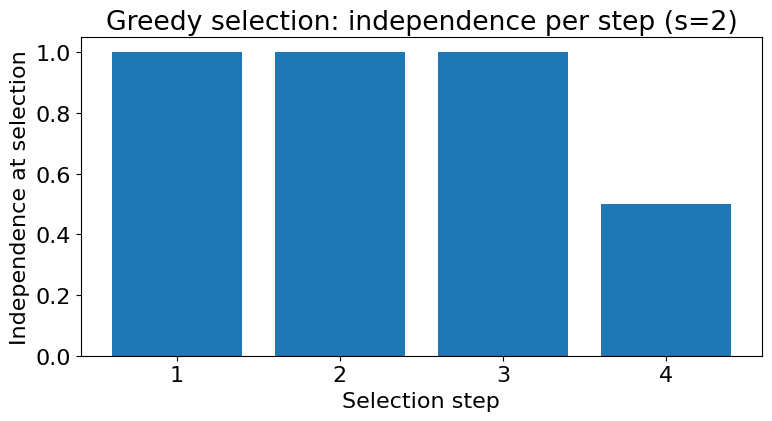

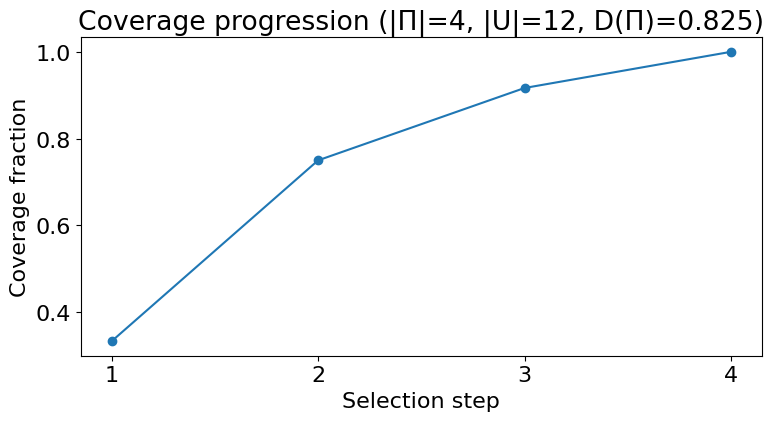

In [ ]:
# plot summary
plot_cover_summary(summary)

In [28]:
# A tidy step-by-step table of the picked modules
df_cover = summarize_cover_to_dataframe(summary)
display(df_cover)

,step,seed_size,seeds,key,|S|,length,indep_at_pick,coverage_frac
0,1,2,"{var-1-out-1, var-4-out-1}",var-1-out-1|var-4-out-1,4,2,1,0.33
1,2,1,{var-0-out-0},var-0-out-0,5,4,1,0.75
2,3,1,{var-0-out-1},var-0-out-1,2,1,1,0.92
3,4,1,{var-1-out-0},var-1-out-0,2,1,0.5,1


In [ ]:
# Run across s and visualize D(Π*_s) and |Π| trends (to eyeball s*)
df_all = greedy_across_s(cms)
display(df_all)

,s,|U|,|Π|,D(Π)
0,1,12,6,0.71
1,2,12,4,0.82


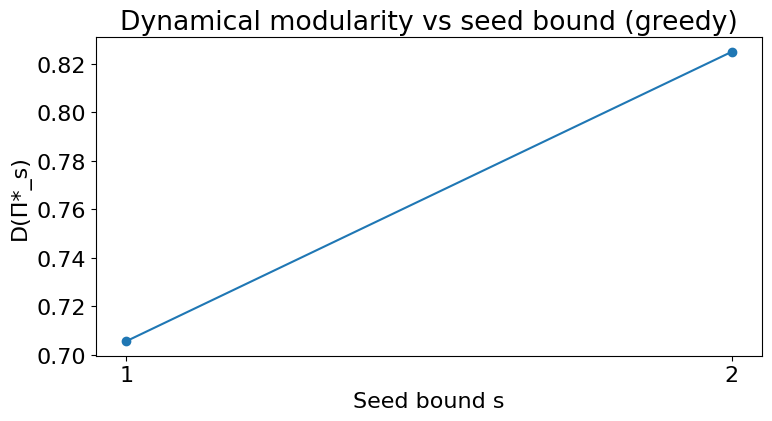

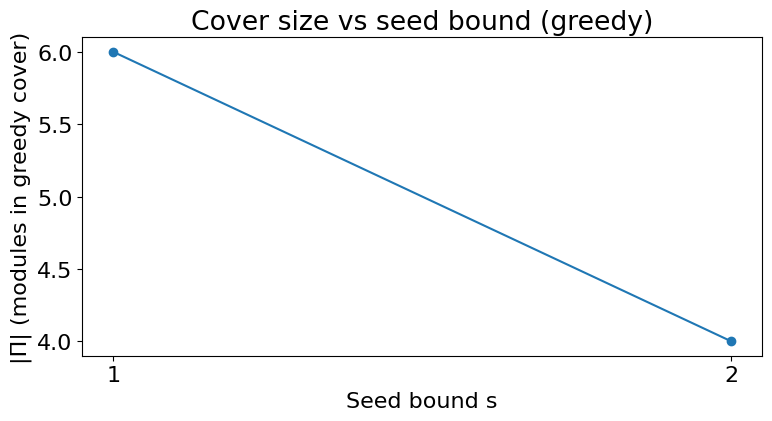

In [41]:
plot_D_vs_s(df_all)

**Drosophila**

In [128]:
ND = DROSOPHILA()
# ND = BooleanNetwork.from_file("./drosophila_parasegment.txt", keep_constants=True) 

In [99]:
cms, selected, summary = dynamical_modularity(ND, 4)

[s=4] step 01 pick: var-0-out-1|var-8-out-0  indep=1.000  coverage=0.441
[s=4] step 02 pick: var-10-out-0  indep=1.000  coverage=0.471
[s=4] step 03 pick: var-0-out-0  indep=1.000  coverage=0.500
[s=4] step 04 pick: var-9-out-1  indep=1.000  coverage=0.529
[s=4] step 05 pick: var-16-out-1  indep=1.000  coverage=0.559
[s=4] step 06 pick: var-3-out-1  indep=0.889  coverage=0.794
[s=4] step 07 pick: var-14-out-1  indep=0.500  coverage=0.882
[s=4] step 08 pick: var-15-out-0  indep=0.500  coverage=0.912
[s=4] step 09 pick: var-7-out-1  indep=0.500  coverage=0.941
[s=4] step 10 pick: var-15-out-1  indep=0.333  coverage=0.971
[s=4] step 11 pick: var-16-out-0  indep=0.143  coverage=1.000


In [103]:
for i in range(1,len(cms.keys())+1):
    print(f"Seed Size {i} # of complex modules: {len(cms[i])}")

Seed Size 1 # of complex modules: 14
Seed Size 2 # of complex modules: 8
Seed Size 3 # of complex modules: 7
Seed Size 4 # of complex modules: 2


In [139]:
dros_DCM = ND.dynamics_canalization_map(output=None, simplify=True)
dros_threshold_DCM = create_threshold_network(dros_DCM)

In [140]:
_, my_cms = gather_complex_modules_till_s(dros_threshold_DCM, s=4)

In [141]:
for i in range(1,len(my_cms.keys())+1):
    print(f"Seed Size {i} # of complex modules: {len(my_cms[i])}")

Seed Size 1 # of complex modules: 14
Seed Size 2 # of complex modules: 8
Seed Size 3 # of complex modules: 7
Seed Size 4 # of complex modules: 2


### **In the Parmer paper, there are a total of 56 complex modules (14+9+19+14) in the Drosophila single cell SPN. Here we get only 33. Not sure why.**

### **Work on adding an exhaustive search cover finding method for maximizing dynamical modularity -- can be used for smaller networks.**

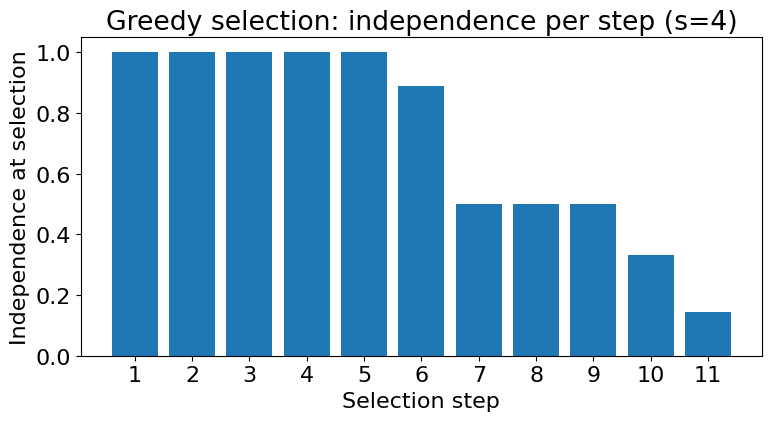

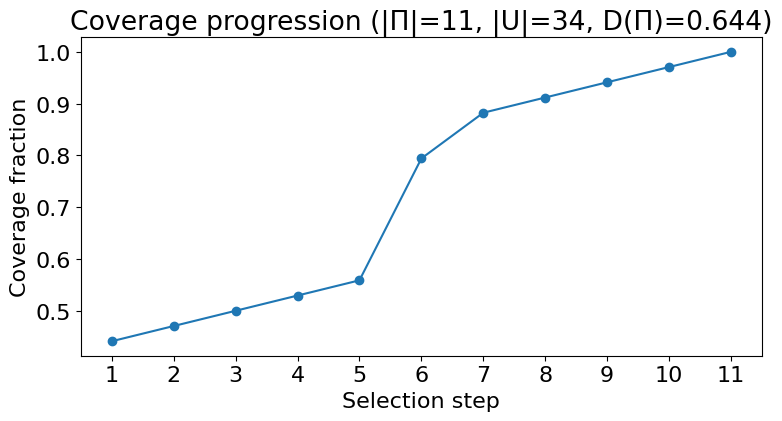

In [56]:
# plot summary
plot_cover_summary(summary)

In [57]:
# A tidy step-by-step table of the picked modules
df_cover = summarize_cover_to_dataframe(summary)
display(df_cover)

,step,seed_size,seeds,key,|S|,length,indep_at_pick,coverage_frac
0,1,2,"{var-0-out-1, var-8-out-0}",var-0-out-1|var-8-out-0,15,7,1,0.44
1,2,1,{var-10-out-0},var-10-out-0,1,0,1,0.47
2,3,1,{var-0-out-0},var-0-out-0,1,0,1,0.5
3,4,1,{var-9-out-1},var-9-out-1,1,0,1,0.53
4,5,1,{var-16-out-1},var-16-out-1,1,0,1,0.56
5,6,1,{var-3-out-1},var-3-out-1,9,6,0.89,0.79
6,7,1,{var-14-out-1},var-14-out-1,6,2,0.5,0.88
7,8,1,{var-15-out-0},var-15-out-0,2,1,0.5,0.91
8,9,1,{var-7-out-1},var-7-out-1,2,1,0.5,0.94
9,10,1,{var-15-out-1},var-15-out-1,3,1,0.33,0.97


In [58]:
# Run across s and visualize D(Π*_s) and |Π| trends (to eyeball s*)
df_all = greedy_across_s(cms)
display(df_all)

,s,|U|,|Π|,D(Π)
0,1,34,14,0.69
1,2,34,11,0.64
2,3,34,11,0.64
3,4,34,11,0.64


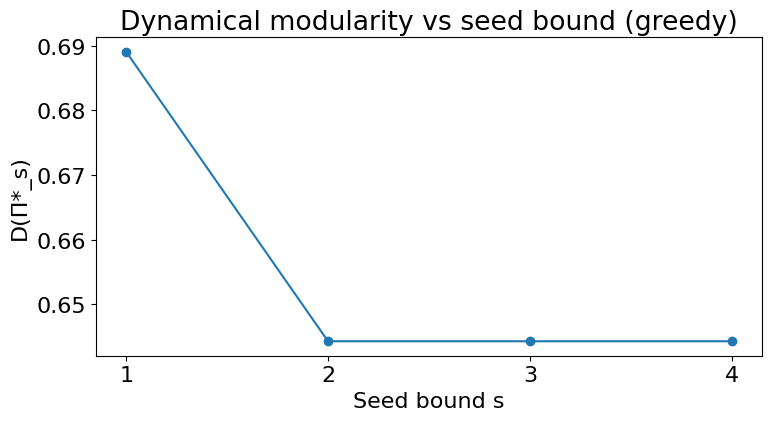

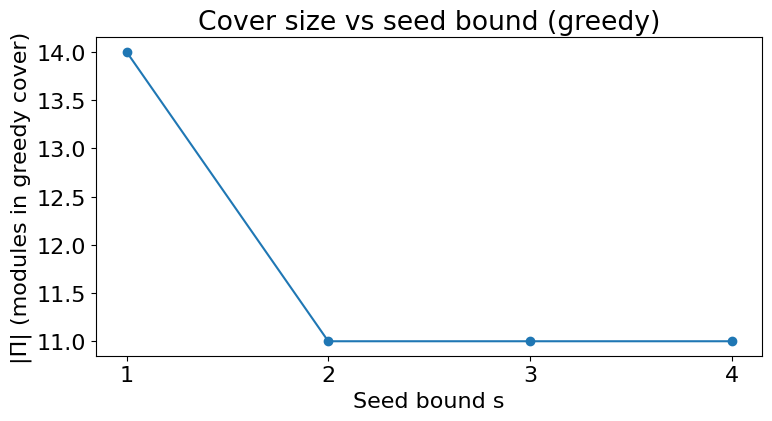

In [59]:
plot_D_vs_s(df_all)  